<a href="https://colab.research.google.com/github/arkadeepsadhukhan-sketch/arkaD-Heston/blob/main/Heston_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

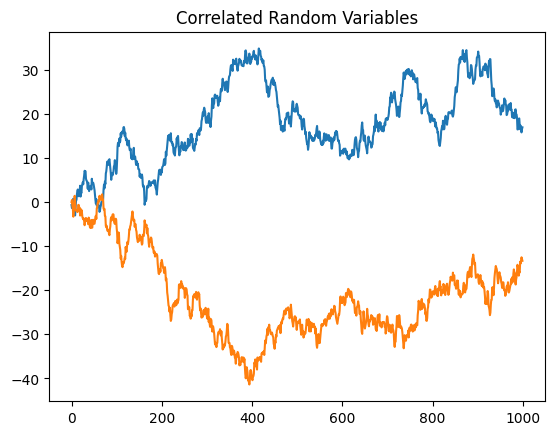

[[ 1.         -0.66610513]
 [-0.66610513  1.        ]]


In [1]:
# This code generates and plots the cumulative sum paths of two correlated
#random variables to simulate correlated random walks.
import numpy as np
import matplotlib.pyplot as plt

rho = -0.7  # vary rho between [-1,1] to visualize different paths
Ndraws = 1000
mu = np.array([0,0]) # mean vector
cov = np.array([[1, rho] , [rho , 1]]) # covariance matrix

W = np.random.multivariate_normal(mu, cov, size=Ndraws)
# generates 1000 pairs of random numbers that follow a multivariate normal
# distribution defined by your mean (mu) and covariance matrix (cov)

plt.plot(W.cumsum(axis=0));
plt.title('Correlated Random Variables')
plt.show()
print(np.corrcoef(W.T))

variable_1 = W[:, 0].cumsum(axis=0)
variable_2 = W[:, 1].cumsum(axis=0)
if Ndraws < 20:
    print(f"varialble 1:{variable_1}")
    print(f"varialble 2:{variable_2}")

 ***Modeling Stochastic Volatility with the Heston Model***

***Objective:***

This project implements the Heston stochastic volatility model to demonstrate its capabilities in capturing complex financial market dynamics that are absent in the standard Black-Scholes model. The primary objectives are to simulate Heston asset paths, generate an implied volatility smile, and analyze the impact of the stock-volatility correlation on the asset price distribution.

Mathematical Formula:
The project employs a Monte Carlo simulation based on the Euler-Maruyama discretization of the Heston model's stochastic differential equations.

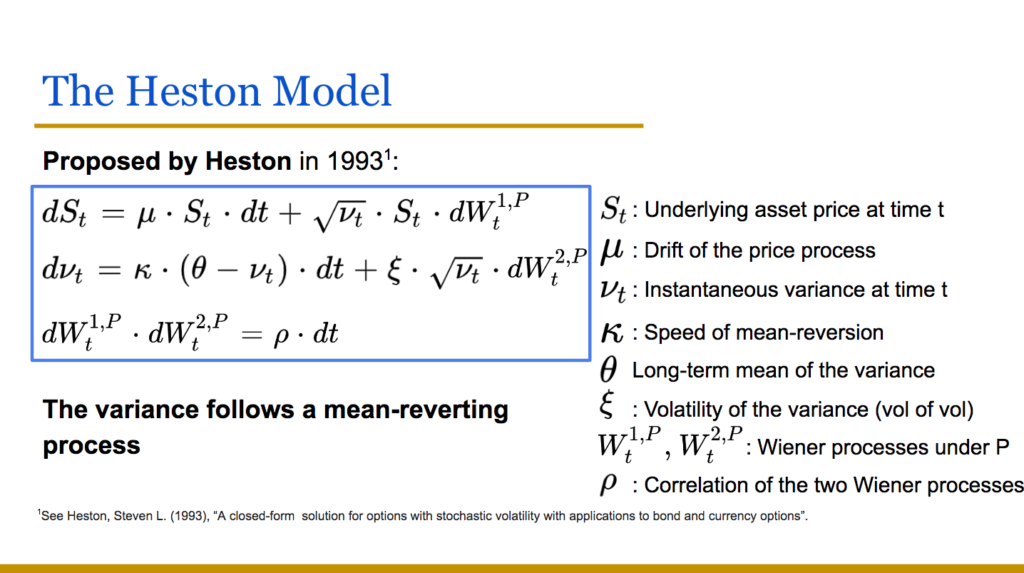


Simulations were conducted for 50,000 paths with varying correlation parameters (ρ=0.9,−0.9,0.0). European put option prices were calculated from the simulated terminal asset prices. Subsequently, an implied volatility for each option was derived by inverting the Black-Scholes formula using a numerical optimizer.

***Results and Analysis:***

The simulation yielded three critical results, visualized in the generated plots:

Implied Volatility Smile: The model successfully generated a non-flat implied volatility curve, exhibiting a "smile" or "skew" shape. This aligns with empirically observed market data and highlights a significant limitation of the constant-volatility Black-Scholes model.

Stochastic Volatility Dynamics: The visualization of individual simulation paths confirms that the model's volatility component is not constant; it is stochastic and exhibits mean reversion, fluctuating around its long-term average θ.

Asset Distribution Skewness: The analysis of terminal price distributions demonstrates that introducing a negative correlation (ρ=−0.9) creates a significant negative skew, or a "fat left tail." This shows the model correctly assigns a higher probability to large, negative market movements compared to the symmetric lognormal distribution assumed by Black-Scholes.

***Conclusion and Significance:***

This project validates the Heston model as a superior framework for option pricing and risk management. It demonstrates that phenomena like the volatility smile and the skewed nature of asset returns are direct consequences of incorporating stochastic, mean-reverting volatility and its correlation with asset returns. The correlation parameter, ρ, is identified as a critical driver of crash risk in equity markets. The findings underscore the importance of moving beyond simplistic models to accurately price derivatives and manage financial risk.


Generating 50000 Heston paths, please be patient ...


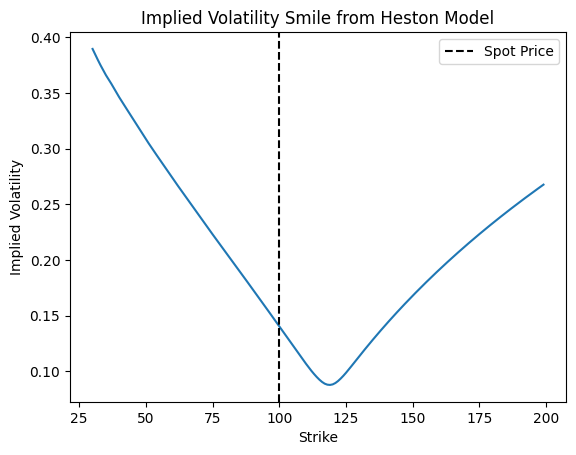

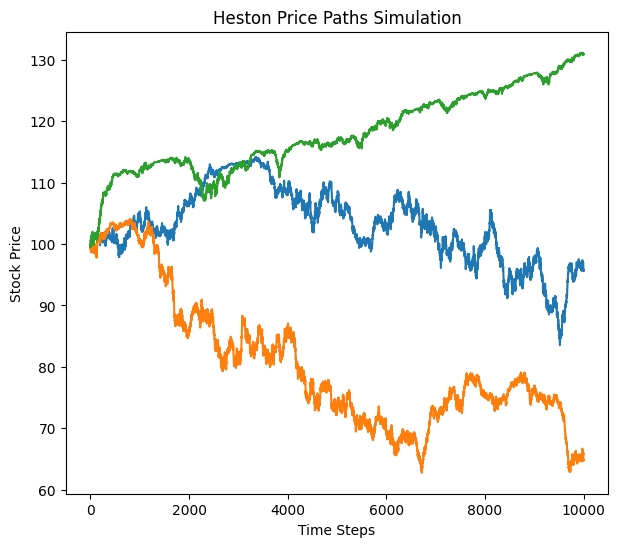

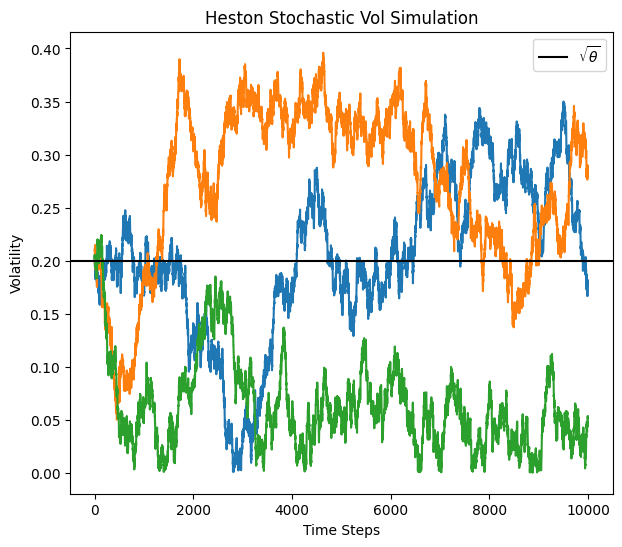

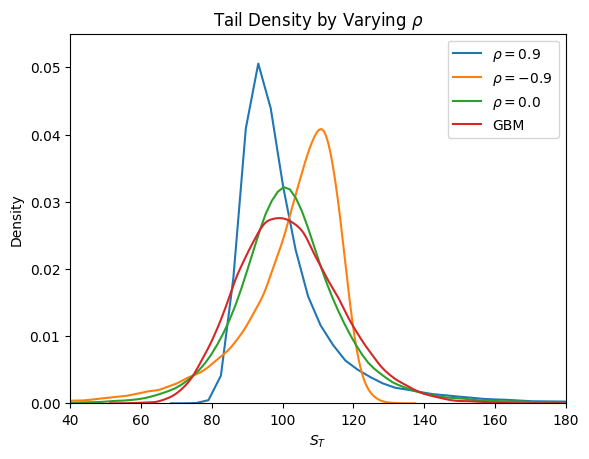

In [2]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import norm
from scipy.optimize import minimize_scalar
N = norm.cdf
kappa =4
theta = 0.02
v_0 =  0.02
xi = 0.9
r = 0.02
S = 100
paths =50000
steps = 2000
T = 1
def BS_CALL(S, K, T, r, sigma):
    d1 = (np.log(S/K) + (r + sigma**2/2)*T) / (sigma*np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    return S * N(d1) - K * np.exp(-r*T)* N(d2)

def BS_PUT(S, K, T, r, sigma):
    d1 = (np.log(S/K) + (r + sigma**2/2)*T) / (sigma*np.sqrt(T))
    d2 = d1 - sigma* np.sqrt(T)
    return K*np.exp(-r*T)*N(-d2) - S*N(-d1)


def implied_vol(opt_value, S, K, T, r, type_='call'):
    def call_obj(sigma):
        return abs(BS_CALL(S, K, T, r, sigma) - opt_value)
    def put_obj(sigma):
        return abs(BS_PUT(S, K, T, r, sigma) - opt_value)
    if type_ == 'call':
        res = minimize_scalar(call_obj, bounds=(0.01,6), method='bounded')
        return res.x
    elif type_ == 'put':
        res = minimize_scalar(put_obj, bounds=(0.01,6),
                              method='bounded')
        return res.x
    else:
        raise ValueError("type_ must be 'put' or 'call'")
def generate_heston_paths(S, T, r, kappa, theta, v_0, rho, xi,
                          steps, Npaths, return_vol=False):
    dt = T/steps
    size = (Npaths, steps)
    prices = np.zeros(size)
    sigs = np.zeros(size)
    S_t = S
    v_t = v_0
    for t in range(steps):
        WT = np.random.multivariate_normal(np.array([0,0]),
                                           cov = np.array([[1,rho],
                                                          [rho,1]]),
                                           size=paths) * np.sqrt(dt)

        S_t = S_t*(np.exp( (r- 0.5*v_t)*dt+ np.sqrt(v_t) *WT[:,0] ) )
        v_t = np.abs(v_t + kappa*(theta-v_t)*dt + xi*np.sqrt(v_t)*WT[:,1])
        prices[:, t] = S_t
        sigs[:, t] = v_t

    if return_vol:
        return prices, sigs

    return prices
print(f"\nGenerating {paths} Heston paths, please be patient ...")
prices_pos = generate_heston_paths(S, T, r, kappa, theta,
                                    v_0, rho=0.9, xi=xi, steps=steps, Npaths=paths,
                                    return_vol=False)[:,-1]
prices_neg  = generate_heston_paths(S, T, r, kappa, theta,
                                    v_0, rho=-0.9, xi=xi, steps=steps, Npaths=paths,
                                    return_vol=False)[:,-1]
prices_zero  = generate_heston_paths(S, T, r, kappa, theta,
                                    v_0, rho=0.0, xi=xi, steps=steps, Npaths=paths,
                                    return_vol=False)[:,-1]
gbm_bench = S*np.exp( np.random.normal((r - v_0/2)*T ,
                                np.sqrt(theta)*np.sqrt(T), size=paths))
strikes =np.arange(30, 200,1)

puts = []
for K in strikes:
    P = np.mean(np.maximum(K-prices_neg,0))*np.exp(-r*T)
    puts.append(P)

ivs = [implied_vol(P, S, K, T, r, type_ = 'put' ) for P, K in zip(puts,strikes)]
plt.plot(strikes, ivs)
plt.ylabel('Implied Volatility')
plt.xlabel('Strike')
plt.axvline(S, color='black',linestyle='--',
            label='Spot Price')
plt.title('Implied Volatility Smile from Heston Model')
plt.legend()
plt.show()
kappa =3
theta = 0.04
v_0 =  0.04
xi = 0.6
r = 0.05
S = 100
paths =3
steps = 10000
T = 1
rho = -0.8
prices,sigs = generate_heston_paths(S, T, r, kappa, theta,
                                    v_0, rho, xi, steps, paths,
                                    return_vol=True)

plt.figure(figsize=(7,6))
plt.plot(prices.T)
plt.title('Heston Price Paths Simulation')
plt.xlabel('Time Steps')
plt.ylabel('Stock Price')
plt.show()

plt.figure(figsize=(7,6))
plt.plot(np.sqrt(sigs).T)
plt.axhline(np.sqrt(theta), color='black', label=r'$\sqrt{\theta}$')
plt.title('Heston Stochastic Vol Simulation')
plt.xlabel('Time Steps')
plt.ylabel('Volatility')
plt.legend()
plt.show()

fig, ax = plt.subplots()
ax = sns.kdeplot(data=prices_pos, label=r"$\rho = 0.9$", ax=ax)
ax = sns.kdeplot(data=prices_neg, label=r"$\rho= -0.9$ ", ax=ax)
ax = sns.kdeplot(data=prices_zero, label=r"$\rho= 0.0$ ", ax=ax)
ax = sns.kdeplot(data=gbm_bench, label="GBM", ax=ax)
ax.set_title(r'Tail Density by Varying $\rho$')
plt.axis([40, 180, 0, 0.055])
plt.xlabel('$S_T$')
plt.ylabel('Density')
ax.legend()
plt.show()